In [3]:
import pylidc as pl
from pylidc.utils import consensus
import matplotlib.pyplot as plt
import numpy as np

from typing import List

In [4]:
from PIL import Image
from gtts import gTTS
#from pytesseract import image_to_string
from scipy.io.wavfile import write

from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import spectrogram


In [5]:
MAX_NODULE_WIDTH = 100
MAX_NODULE_HEIGHT = 100

In [6]:
def zoomout_nodule(bbox, width, height):
    # TODO: what if is outside the picture?
    x_acres = (width - (bbox[0].stop - bbox[0].start))//2
    y_acres = (height - (bbox[1].stop - bbox[1].start))//2

    x_slice = slice(bbox[0].start - x_acres, bbox[0].stop + x_acres, None)
    y_slice = slice(bbox[1].start - y_acres, bbox[1].stop + y_acres, None)

    return (x_slice, y_slice, bbox[2])

Loading dicom files ... This may take a moment.


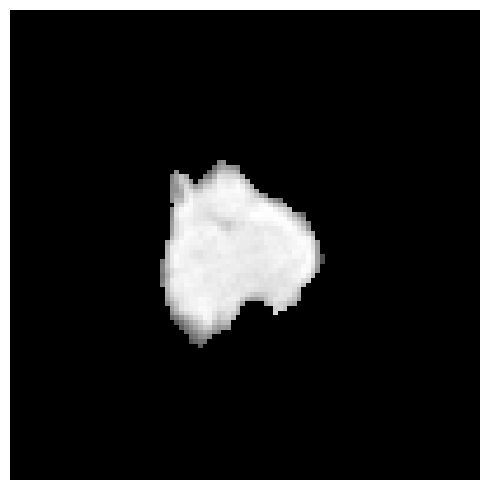

In [7]:
def get_cropped_annot(scan: pl.Scan, mask: bool=False):
    vol = scan.to_volume()

    images = []
    masks = []

    nods = scan.cluster_annotations()
    for anns in nods:
        cmask, cbbox, masks = consensus(anns, clevel=0.5,
                                pad=[(10,10), (10,10), (0,0)])

        full_mask = np.full_like(vol, False, dtype=bool)
        full_mask[cbbox] = cmask

        cbbox = zoomout_nodule(cbbox, MAX_NODULE_WIDTH, MAX_NODULE_HEIGHT)
        cropped = vol[cbbox]
        cropped_mask = ~full_mask[cbbox]
        if mask:
            cropped[cropped_mask] = -1000 # TODO: maybe pick different value

        # Scale values
        # TODO: maybe pick different values
        cropped += 1000
        cropped = cropped / 2000

        images.append(cropped)
        masks.append(cropped_mask)

    return images, masks


scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0001').first()
cropped, _ = get_cropped_annot(scan, True)

# Set up the plot.
plt.figure(figsize=(5,5))
k = int(0.5*cropped[0].shape[2])
plt.imshow(cropped[0][:,:,k], cmap=plt.cm.gray)


plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
''' 
por imagem
converter em som
'''
image_data = cropped[0][:,:,k]  

# Convert NumPy array to a Pillow Image
img = Image.fromarray(image_data).convert('L')

img_data = np.array(img)

# Normalize pixel values to a frequency range (e.g., 20 Hz to 20,000 Hz)
min_freq = 20      # Minimum frequency (Hz)
max_freq = 20000   # Maximum frequency (Hz)

# Normalize the pixel intensities to the frequency range
frequencies = np.interp(img_data, [0, 255], [min_freq, max_freq])

# Generate a sine wave for each pixel
sample_rate = 44100  # Standard sampling rate for audio (Hz)
duration = 0.01      # Duration of each pixel's sound (seconds)

def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = 0.5 * np.sin(2 * np.pi * frequency * t)
    return wave

# Create an audio array by stacking sine waves
audio_data = np.hstack([generate_sine_wave(freq, duration, sample_rate) for freq in frequencies.flatten()])

# Normalize the audio data
audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)

# Save the result as a WAV file
#write("image_to_sound.wav", sample_rate, audio_data)


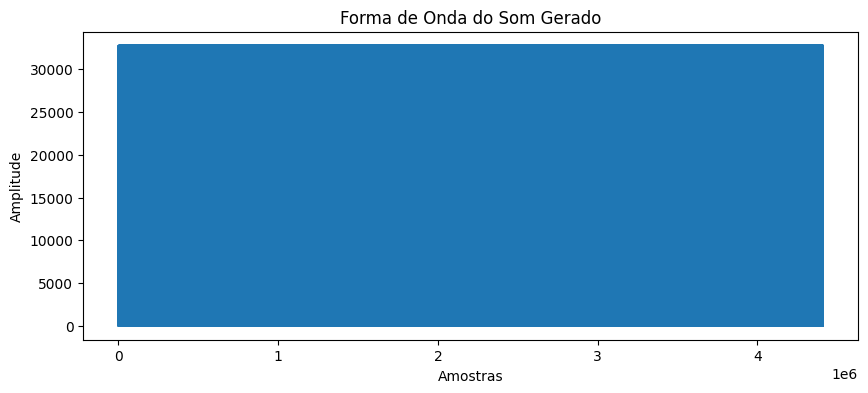

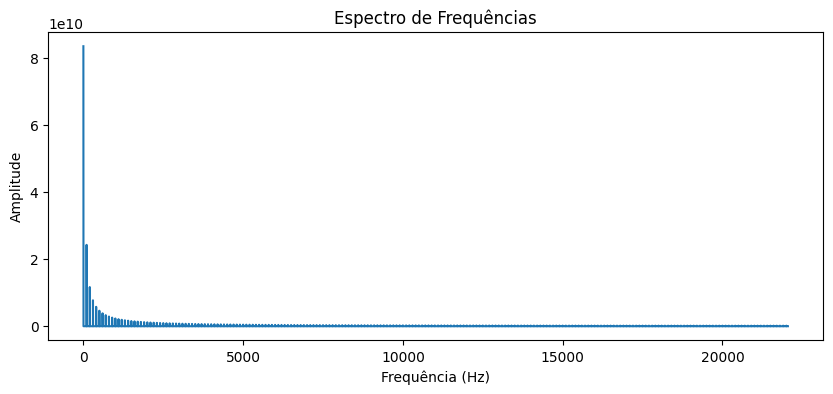

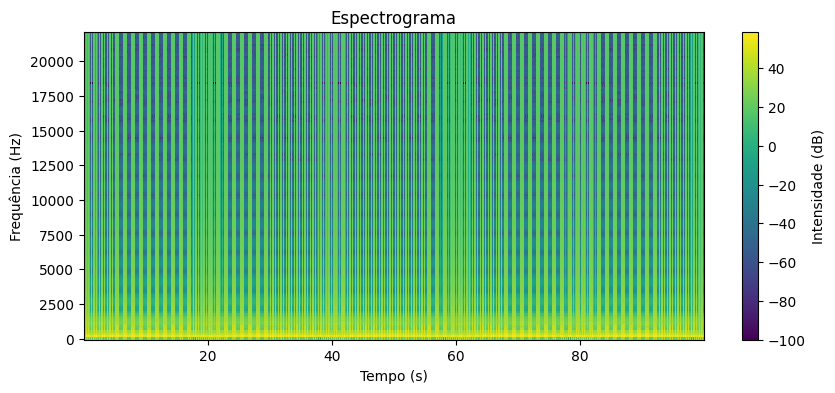

In [9]:
''' 
intencidade
frequência 
espectograma(variação das frequências)
tempo do audio
frequência fundamental
taxa de cruzamento por zero
energia
'''

# Análise 1: Forma de Onda (Domínio do Tempo)
plt.figure(figsize=(10, 4))
plt.plot(audio_data)
plt.title('Forma de Onda do Som Gerado')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

# Análise 2: Espectro de Frequências (Domínio da Frequência)
n = len(audio_data)
audio_fft = fft(audio_data)
frequencies = np.fft.fftfreq(n, 1/sample_rate)

# Plotando a metade positiva do espectro
plt.figure(figsize=(10, 4))
plt.plot(frequencies[:n//2], np.abs(audio_fft[:n//2]))
plt.title('Espectro de Frequências')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.show()

# Análise 3: Espectrograma (Domínio da Frequência ao Longo do Tempo)
frequencies, times, Sxx = spectrogram(audio_data, sample_rate)
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma')
plt.colorbar(label='Intensidade (dB)')
plt.show()